In [ ]:
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader')

In [ ]:
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88685 sha256=d10d5cc821eba19cd0a4235f33b1e8b72ee0b7786ce07335234dfcb55362cdd1
  Stored in directory: /root/.cache/pip/wheels/75/c7/b9/986a1ba8adb2afce230e1a497dc11aeb33efef4fc8dfd6c649
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39779 sha256=4919726ad5e57f276933544cc023724ad3db67c32246f641e9562b223c9e740f
  Stored in directory: /root/.cache/pip/wheels/67/23/d1/a4ef8ff88dc9af7b0eeb1b6fd0d90c6057eaad5a2df25f4e3f
Successfully built pyfolio empyrical


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dataloaders import get_data_from_yahoo

In [ ]:
ticker = "MSFT"

In [ ]:
start_date = "2013-01-01"
end_date = "2023-03-31"

In [ ]:
stock = get_data_from_yahoo.get_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
connected to yahoo


In [ ]:
import yfinance as yf
df = pd.DataFrame()
AAPL  = yf.download("AAPL" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Apple
AMZN  = yf.download("AMZN" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Amazon
GOOG  = yf.download("GOOG", start="2013-01-01", end="2023-03-31",group_by="ticker") # Google (Alphabet)
MSFT  = yf.download("MSFT" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Microsoft



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


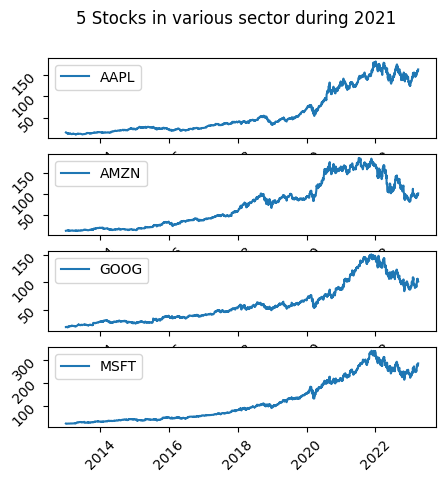

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_figwidth(5)
fig.suptitle('5 Stocks in various sector during 2021')

ax1.plot(AAPL['Adj Close'], label='AAPL')
ax2.plot(AMZN['Adj Close'], label='AMZN')
ax3.plot(GOOG['Adj Close'], label='GOOG')
ax4.plot(MSFT['Adj Close'], label='MSFT')
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
ax4.tick_params(labelrotation=45)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

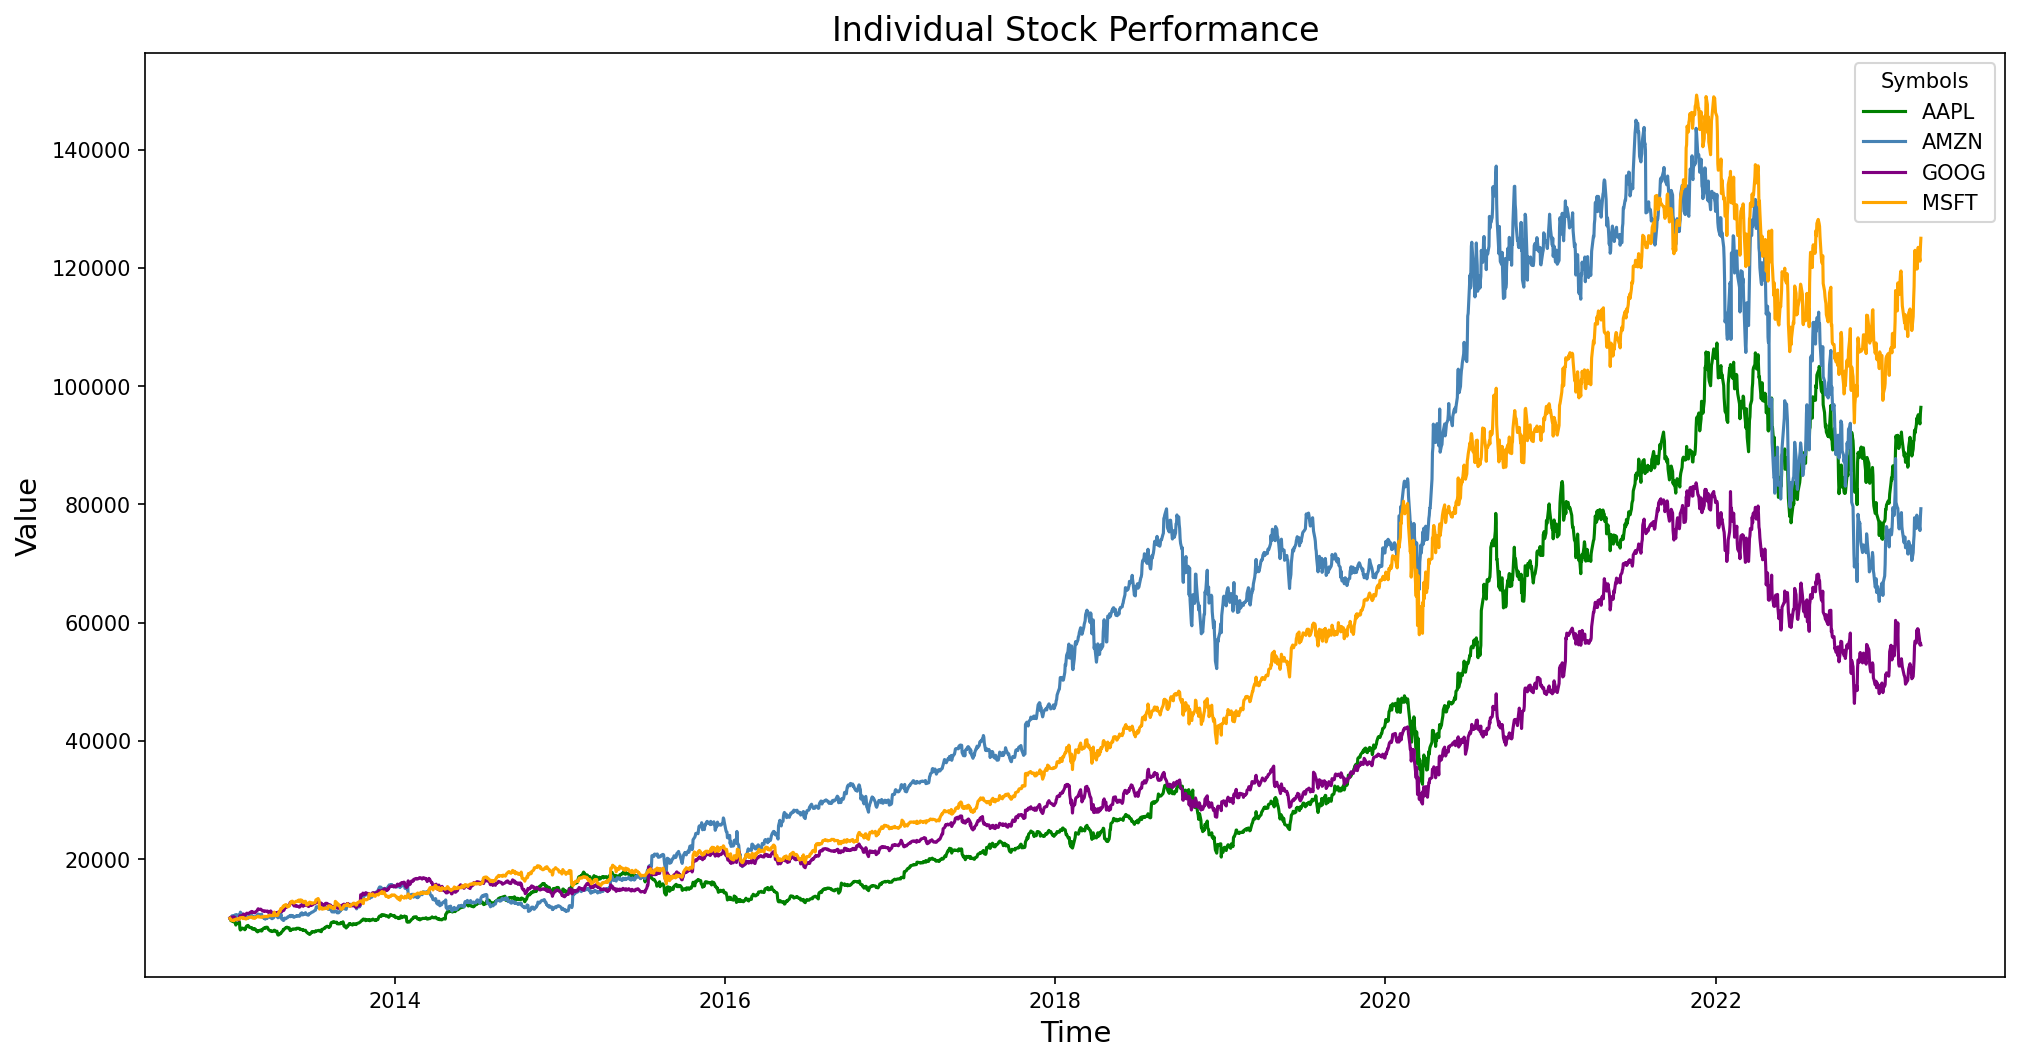

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8), dpi=150)

#plot each series
plt.plot(10000*AAPL['Adj Close']/AAPL['Adj Close'][0], label='AAPL', color='green')
plt.plot(10000*AMZN['Adj Close']/AMZN['Adj Close'][0], label='AMZN', color='steelblue')
plt.plot(10000*GOOG['Adj Close']/GOOG['Adj Close'][0], label='GOOG', color='purple')
plt.plot(10000*MSFT['Adj Close']/MSFT['Adj Close'][0], label='MSFT', color='orange')

#add legend
plt.legend(title='Symbols')

#add axes labels and a title
plt.ylabel('Value', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Individual Stock Performance', fontsize=16)


#display plot
plt.show()

In [ ]:
def f_normalize_data(df):
    """normalizes stock data in respect to price in day 1, 
    this way price on the first day starts at 1$ for any given stock"""
    return df/df.iloc[0,:]   
    
def f_plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    
    ax = df.plot(title=title, fontsize=12, figsize=(20, 10))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    
    #plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    plt.title('Relative price change')
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.style.use('bmh')
    plt.grid(True)
    plt.show()

In [ ]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [ ]:
def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(stock, 20, 2)

In [ ]:
df['RSI'] = computeRSI(df['Adj Close'], 14)

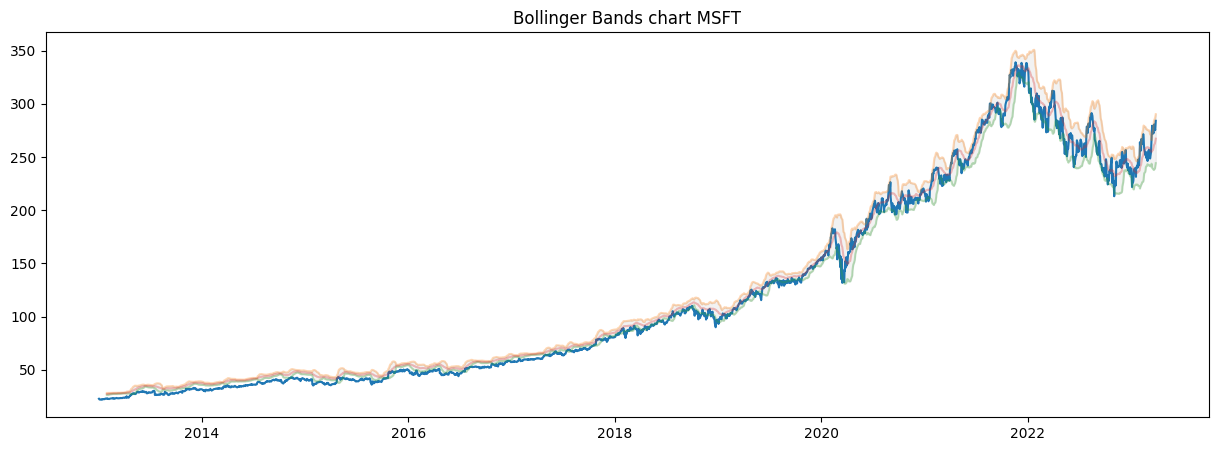

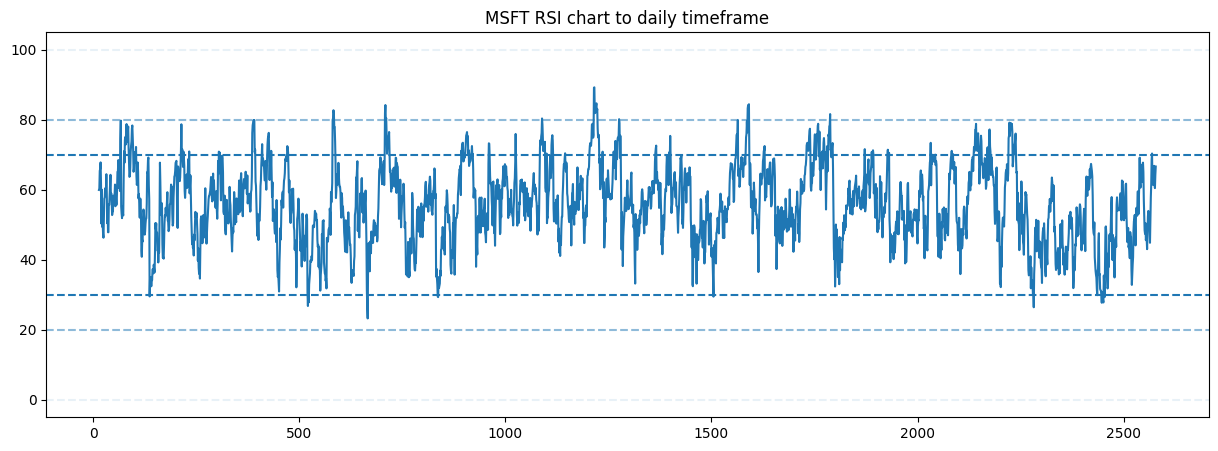

In [ ]:
# plot price
'''
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()
'''
# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'], alpha=0.3)
plt.plot(df['Date'], df['BL'], alpha=0.3)
plt.plot(df['Date'], df['B_MA'], alpha=0.3)
plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

# plot corresponding RSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.title('{} RSI chart to {} timeframe'.format(ticker, 'daily'))
plt.plot(df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)

plt.show()

In [ ]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df.set_index('Date', inplace=True)
df_agg = df.resample('W').agg(agg_dict)
df_agg = df_agg.reset_index()

In [ ]:
# add BB columns
n = 20   # datapoint rolling window
m = 2    # sigma width
df_agg = bollinger_bands(df_agg, 20, 2)

In [ ]:
def add_signal(df):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(df['Close'])):
        #if df['Close'][i] > df['BU'][i]:           # sell signal     daily
        if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        #elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
        elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [ ]:
df_agg['RSI'] = computeRSI(df_agg['Adj Close'], 14)

In [ ]:
def plot_signals(df, ticker):
    # plot price
    #plt.figure(figsize=(15,5))
    #plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    #plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')

    plt.figure(figsize=(15,5))
    plt.title('RSI chart')
    plt.title('{} RSI chart to {} timeframe'.format(ticker, 'weekly'))
    plt.plot(df['RSI'])

    plt.axhline(0, linestyle='--', alpha=0.1)
    plt.axhline(20, linestyle='--', alpha=0.5)
    plt.axhline(30, linestyle='--')

    plt.axhline(70, linestyle='--')
    plt.axhline(80, linestyle='--', alpha=0.5)
    plt.axhline(100, linestyle='--', alpha=0.1)

    plt.legend()

    plt.show()

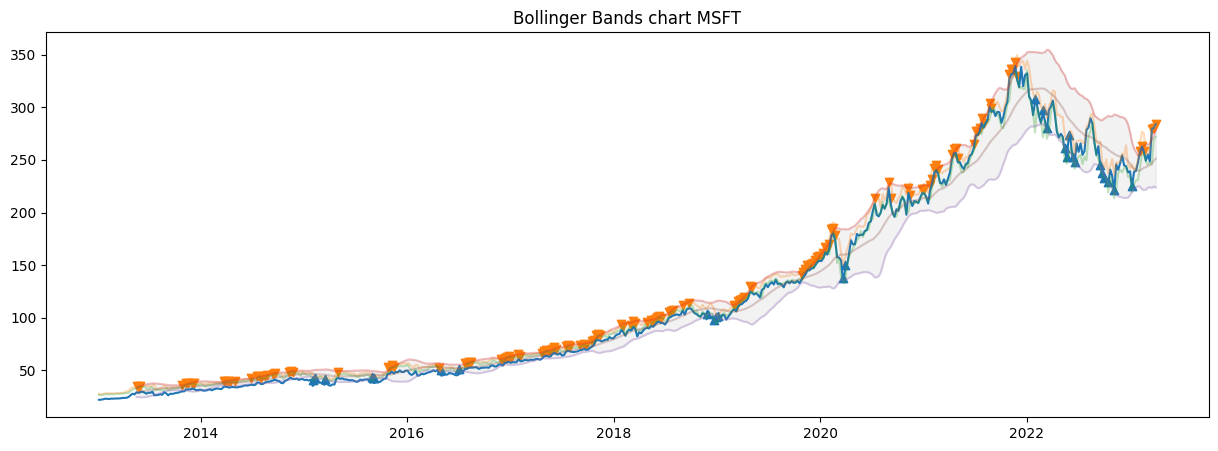

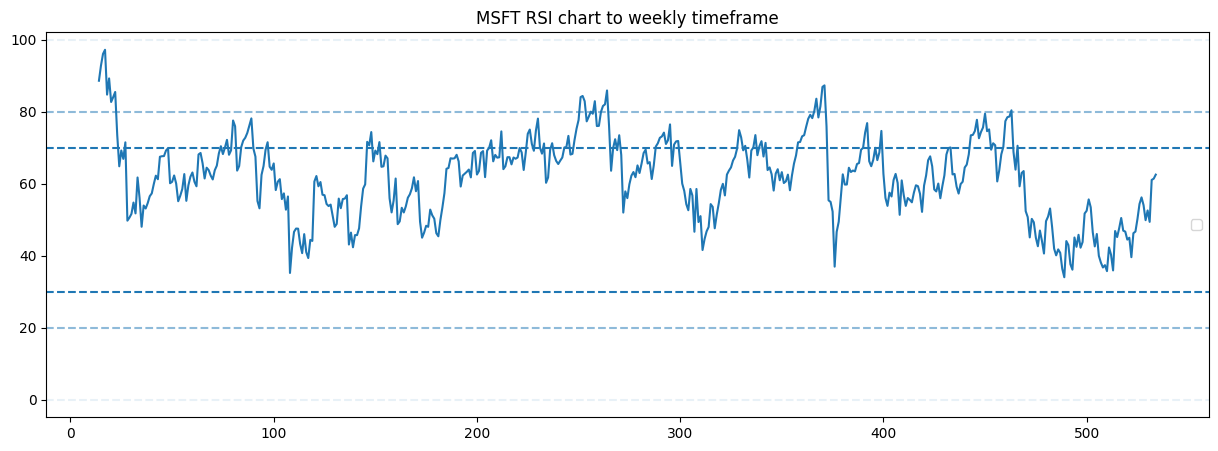

In [ ]:
df_agg = add_signal(df_agg)
plot_signals(df_agg, ticker)

In [ ]:
data = stock
data['daily_returns'] = np.log(data['Adj Close']  / data['Adj Close'].shift(1))
data['bnh_returns'] = data['daily_returns'].cumsum()
data.dropna(inplace=True)

In [ ]:
def prepare_indicators(window):
    data['moving_avg'] = data['Adj Close'].rolling(window=window).mean()
    data['moving_std'] = data['Adj Close'].rolling(window=window).std()

In [ ]:
def backtest_strategy(window, start=None):
	prepare_indicators(window)
	data['upper_band'] = 	data['moving_avg'] + 2 * data['moving_std']
	data['lower_band'] = 	data['moving_avg'] - 2 * data['moving_std']

	if start is None:
		start = window

	# BUY condition
	data['signal'] = 	np.where((data['Adj Close'] < data['lower_band']) &
			 (data['Adj Close'].shift(1) >= data['lower_band']), 1, 0)

	# SELL condition
	data['signal'] = 	np.where((data['Adj Close'] > data['upper_band']) &
			 (data['Adj Close'].shift(1) <= data['upper_band']), -1,
			  data['signal'])

	data['position'] = data['signal'].replace(to_replace=0, method='ffill')
	data['position'] = data['position'].shift()

	data['strategy_returns'] = data['position'] * data['daily_returns']

	performance = data[['daily_returns', 'strategy_returns']].iloc[start:].sum()

	data['strategy_returns'] = data['strategy_returns'].cumsum()
	return performance

In [ ]:
def optimize_bollinger_band_parameters(windows):
	start = max(windows)
	results = pd.DataFrame()
	for window in windows:
		perf = backtest_strategy(window=window, start=start)
		result = pd.DataFrame({'Window': window,
									'bnh returns': perf['daily_returns'],
									'strategy returns': perf['strategy_returns']}, 
									 index=[0, ])
		results = results.append(result, ignore_index=True)
	results.sort_values(by='strategy returns', inplace=True, ascending=False)
	results = results.reset_index()
	return  results.drop("index", axis=1)

In [ ]:
def plot_data( attribute_list):
    data[attribute_list].plot()
    plt.show()

In [ ]:
def plot_optimized_bollinger_strategy_returns(results):
  if (len(results)) > 0:
    window = results.loc[0, 'Window']
    print("Window:", window)
    backtest_strategy(window=window)
    data[['bnh_returns', 'strategy_returns']].plot()
    plt.show()
    

In [ ]:
results = optimize_bollinger_band_parameters(range(1, 50, 1))

<ipython-input-60-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-60-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-60-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-60-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-60-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed

Window: 38


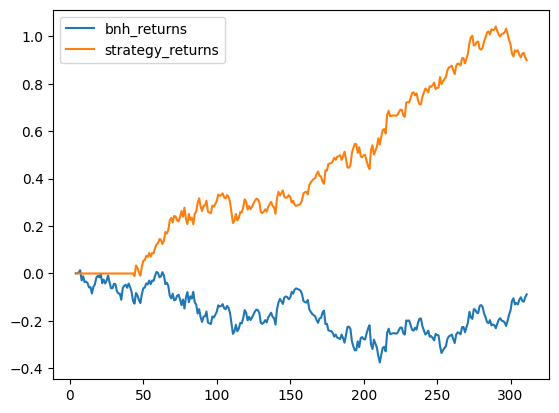

In [ ]:
plot_optimized_bollinger_strategy_returns(results)

In [ ]:
import pyfolio as pf

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
 # function to create a simple tear sheet using pyfolio
def create_simple_tear_sheet(data):
    pf.display(\
    pf.create_simple_tear_sheet(data['strategy_returns'].diff()))

In [ ]:
create_simple_tear_sheet(data)

/usr/local/lib/python3.9/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


AttributeError: ignored